In [1]:
pwd

'/home/vmu/nu_stats'

In [2]:
%cd examples/bayes_hierarchical_model/

/home/vmu/nu_stats/examples/bayes_hierarchical_model


In [3]:
%load_ext autoreload
%autoreload 2

# SIM

In [4]:
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt

In [5]:
import sys
sys.path.append("../../")
from nu_stats.simulation import Simulation
from nu_stats.plotting import unit_vectors_skymap as u_v_s

In [6]:
# Simulation parameters
L = 1e48 * (u.erg/u.s)
gamma = 2.2
z = 0.3
F_diff_norm = 1e-15 * 1/(u.GeV * u.cm**2 * u.s)
Emin = 1e5 * u.GeV
Emax = 1e8 * u.GeV
Enorm = 1e5 * u.GeV

In [7]:
sim = Simulation(L, gamma, z, F_diff_norm, Emin=Emin, Emax=Emax, Enorm=Enorm)
sim.run(seed=234)


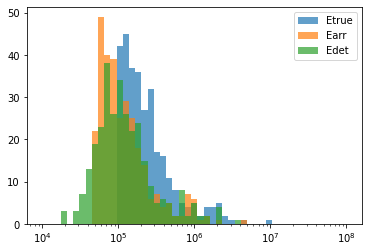

In [8]:
sim.show_spectrum()

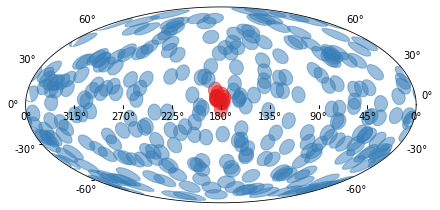

In [9]:
sim.show_skymap()

In [10]:
sim.truth

OrderedDict([('L', 6.2415090744607645e+50),
             ('gamma', 2.2),
             ('F_bg', 8.331240094640407e-07),
             ('f', 0.05463271416561316)])

In [11]:
# Extract simulated data and get info needed for fit
fit_input = sim.get_data()

# FQTIST FIT

In [12]:
from nu_stats.fqutils import FqStructure, plot_loghist

In [13]:
fq = FqStructure()
fq.construct_diffuse_bg_energy_likelihood(
    fit_input['z_bg'], Emin, Emax, min_index=1.5, max_index=4.0, n_Esim=100000,
    Nbins=25, prefab_likelihood_file='tmp/False1.0_25lik.npy'
    )
fq.construct_source_energy_likelihood(
    fit_input['z'], Emin, Emax, min_index=1.5, max_index=4.0, n_Esim=100000,
    Nbins=25, prefab_likelihood_file='tmp/True0.3_25lik.npy'
)

Generating marginalized background energy likelihood..
Separate marginalized energy likelihood generated for bg.
Generating marginalized energy likelihood..
Marginalized energy likelihood generated.


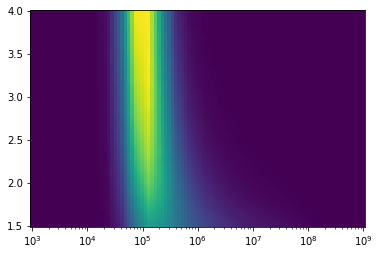

In [14]:
fq.energy_likelihood.plot_pdf_meshgrid();

In [15]:
fq.fit_input = fit_input

In [16]:
m, mn_h, mg_h = fq.minimize_neg_lbl()


In [17]:
m.minos()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1862                       │              Nfcn = 134              │
│ EDM = 3.75e-07 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_s   │   11.5    │    3.5    │    -3.1    │    3.8     │    0    │   304   │       │
│ 1 │ gamma │   2.23    │   0.08    │   -0.10    │    0.08    │   1.5   │    4    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │          n_s          │         gamma         │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -3.1    │    3.8    │   -0.10   │   0.08    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬─────────────────┐
│       │     n_s   gamma │
├───────┼─────────────────┤
│   n_s │    11.9 0.00178 │
│ gamma │ 0.00178  0.0068 │
└───────┴─────────────────┘

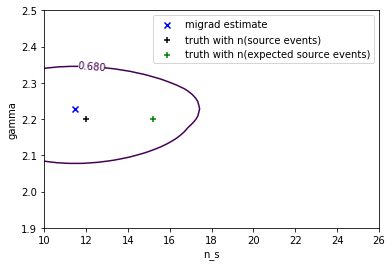

In [18]:
m.draw_mncontour('n_s','gamma')
plt.scatter(mn_h, mg_h, marker='x', c ='b')
plt.scatter(sum(sim.labels==0),sim.truth['gamma'], marker='+', c ='k')
plt.scatter(sim.Nex_ps, sim.truth['gamma'], marker='+', c ='g')
plt.legend(['migrad estimate', 'truth with n(source events)','truth with n(expected source events)'])
plt.xlim((10,26))
plt.ylim((1.9,2.5))
plt.show()

# BHM

In [19]:
from nu_stats.bhmutils import BhStructure

In [20]:
bhm = BhStructure(fit_input)
bhm.load_model("stan/toy_bhm.stan")

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/vmu/nu_stats/examples/bayes_hierarchical_model/stan/toy_bhm


In [21]:
bhm.run(seed=0)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


In [22]:
bhm.vars.keys()

dict_keys(['gamma', 'L', 'F_bg', 'Etrue', 'f', 'F_src', 'F', 'Nex', 'Nex_ps', 'Nex_bg', 'eps', 'log_prob', 'Earr'])

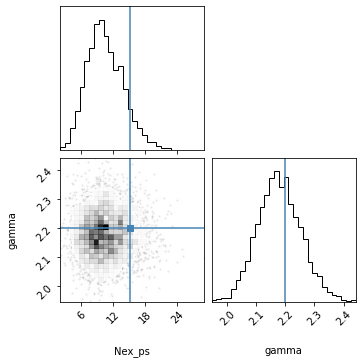

In [23]:
bhm.plot_corner(['Nex_ps','gamma'], [sim.Nex_ps, sim.gamma], bins=30,plot_contours=False)

In [24]:
bhm.print_summary()

                   Mean          MCSE        StdDev            5%  \
name                                                                
lp__      -9.700000e+03  4.200000e-01  1.400000e+01 -9.700000e+03   
gamma      2.200000e+00  1.300000e-03  7.500000e-02  2.100000e+00   
L          4.600000e+50  2.400000e+48  1.700000e+50  2.300000e+50   
F_bg       9.300000e-07  6.900000e-10  5.500000e-08  8.400000e-07   
Etrue[1]   3.130550e+05  2.068000e+03  1.660040e+05  1.276140e+05   
...                 ...           ...           ...           ...   
Earr[301]  1.060190e+05  5.850000e+02  4.854900e+04  5.448700e+04   
Earr[302]  7.671100e+04  3.300000e+02  2.606700e+04  5.152300e+04   
Earr[303]  8.083400e+04  4.110000e+02  3.069900e+04  5.166100e+04   
Earr[304]  1.154710e+05  7.510000e+02  5.668300e+04  5.467300e+04   
Earr[305]  7.132000e+04  2.700000e+02  2.156800e+04  5.109100e+04   

                    50%           95%   N_Eff  N_Eff/s  R_hat  
name                                  

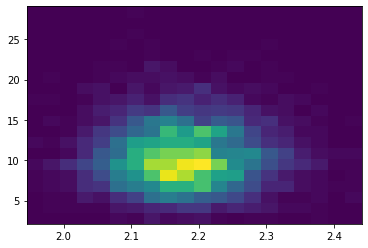

In [25]:
plt.hist2d(bhm.fit.stan_variable('gamma'), bhm.fit.stan_variable('Nex_ps'), bins=20);

In [26]:
import arviz as az

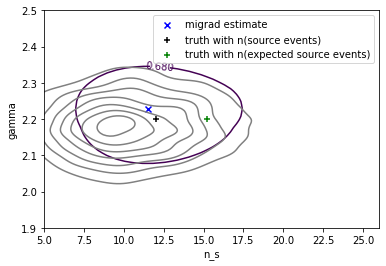

In [27]:
m.draw_mncontour('n_s','gamma')
ax = plt.gca()
plt.scatter(mn_h, mg_h, marker='x', c ='b')
plt.scatter(sum(sim.labels==0),sim.truth['gamma'], marker='+', c ='k')
plt.scatter(sim.Nex_ps, sim.truth['gamma'], marker='+', c ='g')
plt.legend(['migrad estimate', 'truth with n(source events)','truth with n(expected source events)'])
az.plot_kde(bhm.fit.stan_variable('Nex_ps'),bhm.fit.stan_variable('gamma'),
    contourf_kwargs={'alpha':0}, contour_kwargs={})
plt.xlim((5,26))
plt.ylim((1.9,2.5))
plt.show()

In [28]:
az.hdi(bhm.fit.stan_variable('gamma'), hdi_prob=.68)

array([2.10405, 2.25138])

In [29]:
m

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1862                       │              Nfcn = 134              │
│ EDM = 3.75e-07 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_s   │   11.5    │    3.5    │    -3.1    │    3.8     │    0    │   304   │       │
│ 1 │ gamma │   2.23    │   0.08    │   -0.10    │    0.08    │   1.5   │    4    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │          n_s          │         gamma         │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -3.1    │    3.8    │   -0.10   │   0.08    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬─────────────────┐
│       │     n_s   gamma │
├───────┼─────────────────┤
│   n_s │    11.9 0.00178 │
│ gamma │ 0.00178  0.0068 │
└───────┴─────────────────┘

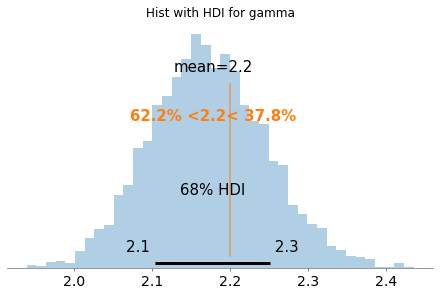

In [30]:
az.plot_posterior(bhm.fit.stan_variable('gamma'),
    hdi_prob=.68,
    ref_val = sim.truth['gamma'],
    kind='hist',
)
plt.title('Hist with HDI for gamma')
plt.show()

In [31]:
bhm.fit.stan_variable('gamma').mean()

2.1785696275

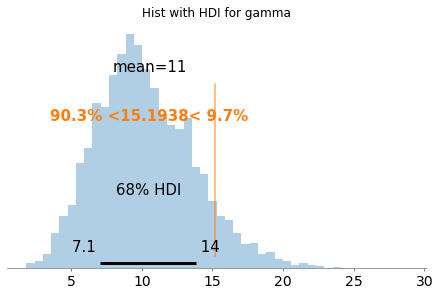

In [40]:
az.plot_posterior(bhm.fit.stan_variable('Nex_ps'),
    hdi_prob=.68,
    ref_val = sim.Nex_ps,
    kind = 'hist',
)
plt.title('Hist with HDI for gamma')
plt.show()

<AxesSubplot:xlabel='gamma', ylabel='Nex_ps'>

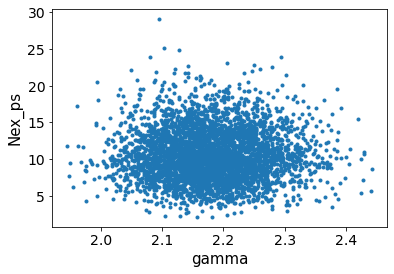

In [33]:
az.plot_pair(bhm.fit, var_names=['gamma','Nex_ps'])

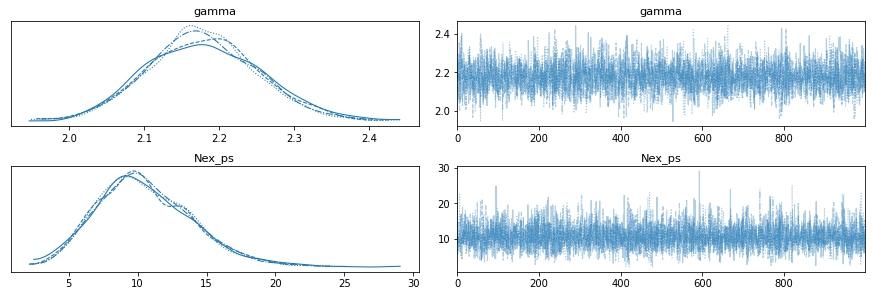

In [34]:
bhm.plot_traces(var_names=['gamma','Nex_ps'])

In [35]:
bhm.print_diagnostic()

INFO:cmdstanpy:Processing csv files: /tmp/tmpewo43u7w/toy_bhm-202104112214-1-ylbvc39g.csv, /tmp/tmpewo43u7w/toy_bhm-202104112214-2-4d76gt22.csv, /tmp/tmpewo43u7w/toy_bhm-202104112214-3-qfe1_h54.csv, /tmp/tmpewo43u7w/toy_bhm-202104112214-4-6oxue2un.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.
